<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified LSTM Activity Classifier

In this notebook, we modify the baseLSTM neural net to classify PE activity.

#### Load dependencies

In [2]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional, LeakyReLU, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint 
import os 
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

#### Set hyperparameters

In [26]:
# output directory name:
output_dir = 'model_output/lstm2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# LSTM layer architecture:
n_lstm_1 = 128 
n_lstm_2 = 128 
n_lstm_3 = 64
drop_lstm_1 = 0.0
drop_lstm_2 = 0.05
drop_lstm_3 = 0.05


# dense layer architecture: 
n_dense_1 = 256
dropout_1 = 0.2
n_dense_2 = 256
dropout_2 = 0.2
n_dense_3 = 128
dropout_3 = 0.25

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [27]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [28]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [29]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [30]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [31]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]


#### Design neural network architecture

In [32]:
model = Sequential()
# model.add(Flatten(input_shape=input_shape[1:]))
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True, input_shape=input_shape[1:])) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
model.add(LSTM(n_lstm_3, dropout=drop_lstm_3, 
                             return_sequences=True)) 
# model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm_2)))
# model.add(GlobalMaxPooling1D())
# model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_dense_3, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_3))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 90, 128)           67584     
_________________________________________________________________
lstm_7 (LSTM)                (None, 90, 128)           131584    
_________________________________________________________________
lstm_8 (LSTM)                (None, 90, 64)            49408     
_________________________________________________________________
flatten_2 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               1474816   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

### Splitting and shuffeling the data

In [33]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [35]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [36]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [37]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/60
228/228 [==============================] - 12s 51ms/step - loss: 1.2473 - accuracy: 0.4668 - val_loss: 0.9157 - val_accuracy: 0.6106
Epoch 2/60
228/228 [==============================] - 11s 49ms/step - loss: 0.8015 - accuracy: 0.6646 - val_loss: 0.6063 - val_accuracy: 0.7563
Epoch 3/60
228/228 [==============================] - 11s 49ms/step - loss: 0.6044 - accuracy: 0.7536 - val_loss: 0.5374 - val_accuracy: 0.7857
Epoch 4/60
228/228 [==============================] - 11s 49ms/step - loss: 0.5074 - accuracy: 0.7983 - val_loss: 0.4794 - val_accuracy: 0.8107
Epoch 5/60
228/228 [==============================] - 11s 49ms/step - loss: 0.4412 - accuracy: 0.8272 - val_loss: 0.4149 - val_accuracy: 0.8485
Epoch 6/60
228/228 [==============================] - 11s 49ms/step - loss: 0.3935 - accuracy: 0.8480 - val_loss: 0.4552 - val_accuracy: 0.8300
Epoch 7/60
228/228 [==============================] - 11s 49ms/step - loss: 0.3670 - accuracy: 0.8582 - val_loss: 0.3487 - val_accuracy:

#### Evaluate

In [38]:
model.load_weights(output_dir+"/weights.49.hdf5") # 94.22 val accuracy

In [39]:
y_hat = model.predict(x_valid)

In [40]:
len(y_hat)

6476

In [41]:
y_hat[0]

array([1.5183621e-03, 1.2306287e-09, 1.9398967e-11, 8.6664807e-11,
       1.1307324e-09, 9.9848169e-01], dtype=float32)

In [42]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

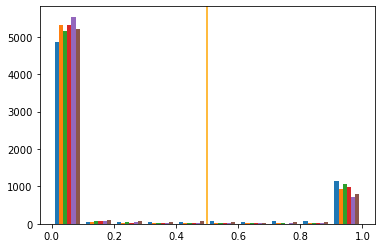

In [43]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [44]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [45]:
"{:0.2f}".format(pct_auc)

'99.52'

In [46]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [47]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [48]:
ydf.head(10)

,y_hat,y
0,"[0.002, 0.0, 0.0, 0.0, 0.0, 0.998]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 0.958, 0.0, 0.0, 0.042, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.004, 0.994, 0.0, 0.0, 0.002, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
